Image analysis converted to 256х256 рх resolution




### Loading images

In [ ]:
from google.colab import files

# File uploading
uploaded = files.upload()

Saving unet_model3 (6).pth to unet_model3 (6).pth


In [ ]:
import zipfile

with zipfile.ZipFile('ZIP file path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

## Single image analysis

**image_path = '/content/æ50_11_σ50-0003.jpg'** - specify the image path here

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

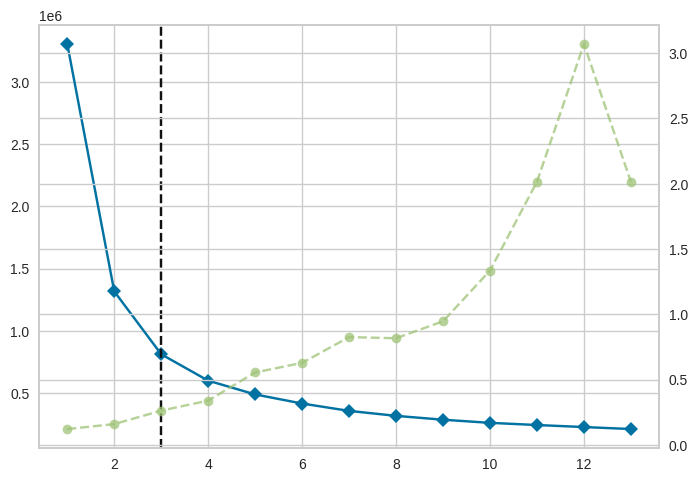

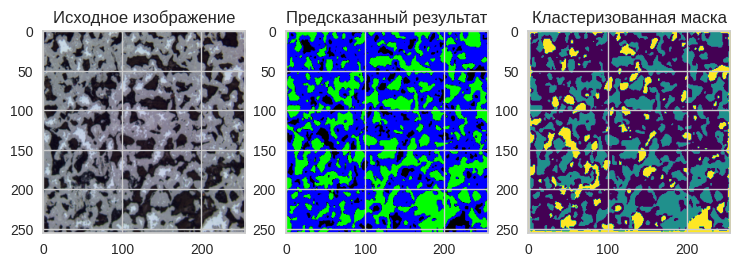

Количество кластеров: 3


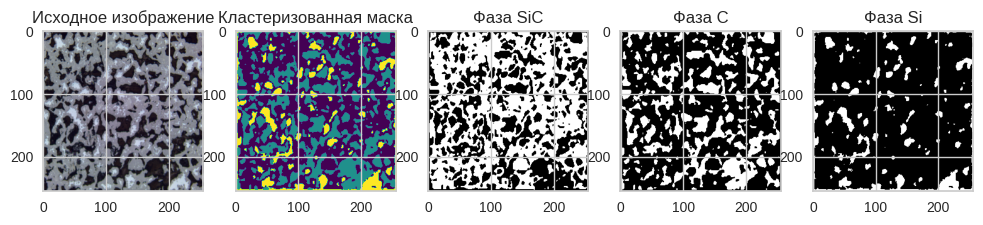


Содержание фазы SiC: 55.50%

Содержание фазы C: 30.16%

Содержание фазы Si: 14.34%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from skimage import color

class CustomDataset(Dataset):
    def __init__(self, image_folder_jpg, transform=None):
        self.image_folder_jpg = image_folder_jpg
        self.transform = transform
        self.jpg_files = [os.path.join(self.image_folder_jpg, filename) for filename in os.listdir(self.image_folder_jpg) if filename.endswith('.jpg')]

    def __len__(self):
        return len(self.jpg_files)

    def __getitem__(self, idx):
        image_path = self.jpg_files[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=3, padding=1),
              nn.ReLU(inplace=True),
              nn.Conv2d(64, 64, kernel_size=3, padding=1),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),
          )

        # Decoding
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
          )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

trained_model = UNet()
# please upload and specify the correct path to the model data unet_modelceramicnorm.pth
trained_model.load_state_dict(torch.load('/content/unet_modelceramicnorm.pth', map_location=torch.device('cpu')))
trained_model.eval()

image_path = '/content/æ50_11_σ50-0003.jpg'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0)

with torch.no_grad():
    output = trained_model(image)
    output = torch.nn.functional.interpolate(output, size=(256, 256), mode='bilinear', align_corners=False)

input_image = image.squeeze(0).permute(1, 2, 0).numpy()
predicted_mask = output[0].permute(1, 2, 0).numpy()
predicted_mask_reshaped = predicted_mask.reshape(-1, 3)

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1, 14))
visualizer.fit(predicted_mask_reshaped)
optimal_num_clusters = visualizer.elbow_value_

if optimal_num_clusters is None or optimal_num_clusters > 3:
    optimal_num_clusters = 3

kmeans = KMeans(n_clusters=optimal_num_clusters, n_init=10, random_state=0)
kmeans.fit(predicted_mask_reshaped)
cluster_labels = kmeans.labels_
clustered_mask = cluster_labels.reshape(predicted_mask.shape[:2])

plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(input_image)
plt.title("Initial image")

plt.subplot(1, 4, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted result (mask)")

plt.subplot(1, 4, 3)
plt.imshow(clustered_mask, cmap='viridis')
plt.title("Clustered mask")
plt.show()

unique_labels, counts = np.unique(cluster_labels, return_counts=True)
num_clusters = len(unique_labels)
total_pixels = np.product(predicted_mask.shape[:2])

print(f"Number of clusters: {num_clusters}")

color_names = ["black", "green", "blue"]
new_thresholds = [(60, 100), (0, 30), (30, 60)]

color_mapping = {
"black": "Si",
"green": "C",
"blue": "SiC"
}

input_image_resized = input_image.reshape(predicted_mask.shape[0], predicted_mask.shape[1], 3)

# Converting color space to Lab
image_lab = color.rgb2lab(input_image_resized)

# Visualize the clusters in Lab color space
def plot_lab_clusters(input_image_lab, clustered_mask, num_clusters):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, num_clusters + 2, 1)
  plt.imshow(color.lab2rgb(input_image_lab))
  plt.title("Initial image")

  plt.subplot(1, num_clusters + 2, 2)
  plt.imshow(clustered_mask, cmap='viridis')
  plt.title("Clustered mask")

  for label in range(num_clusters):
    cluster_mask = clustered_mask == label
    plt.subplot(1, num_clusters + 2, label + 3)
    plt.imshow(cluster_mask, cmap='gray')

# define the cluster color basing on threshold in Lab space
    cluster_pixels_L = input_image_lab[:, :, 0][cluster_mask]
    mean_L = np.mean(cluster_pixels_L)
    cluster_color = None
    for i, (low, high) in enumerate(new_thresholds):
      if low <= mean_L <= high:
        cluster_color = color_names[i]
        break

    if cluster_color is None:
      cluster_color = "undefined"

    cluster_info = color_mapping.get(cluster_color, "undefined")
    plt.title(f"Фаза {cluster_info}")

  plt.show()

plot_lab_clusters(image_lab, clustered_mask, num_clusters)

for label, count in zip(unique_labels, counts):
    percentage = (count / total_pixels) * 100

    image_lab = color.rgb2lab(input_image_resized)


    L_channel = image_lab[:,:,0]
    a_channel = image_lab[:,:,1]
    b_channel = image_lab[:,:,2]

    cluster_mask = clustered_mask == label
    cluster_pixels_L = L_channel[cluster_mask]
    cluster_pixels_a = a_channel[cluster_mask]
    cluster_pixels_b = b_channel[cluster_mask]


    mean_L = np.mean(cluster_pixels_L)
    mean_a = np.mean(cluster_pixels_a)
    mean_b = np.mean(cluster_pixels_b)


    cluster_color = None
    for i, (low, high) in enumerate(new_thresholds):
        if low <= mean_L <= high:
            cluster_color = color_names[i]
            break

    if cluster_color is None:
        cluster_color = "undefined"

    cluster_info = color_mapping.get(cluster_color, "undefined")
    print()
    print(f"Phase content {cluster_info}: {percentage:.2f}%")


## Multiple images analysis

**image_folder = '/content/mineral''** - specify the path to images folder

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

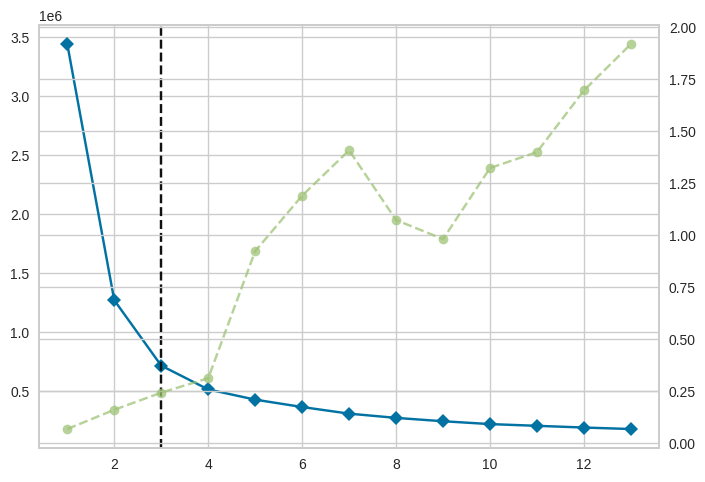

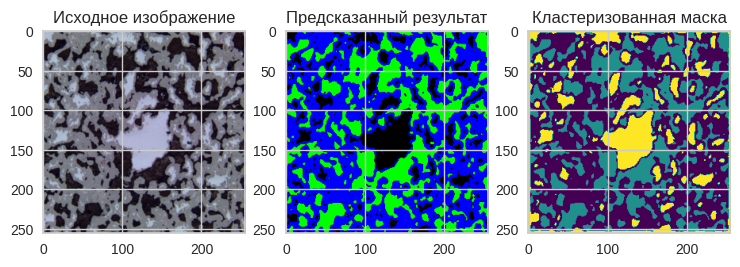

Количество кластеров: 3


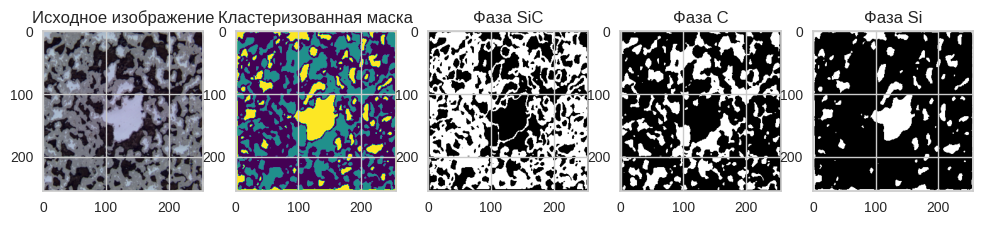


Содержание фазы SiC: 52.80%

Содержание фазы C: 29.24%

Содержание фазы Si: 17.96%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

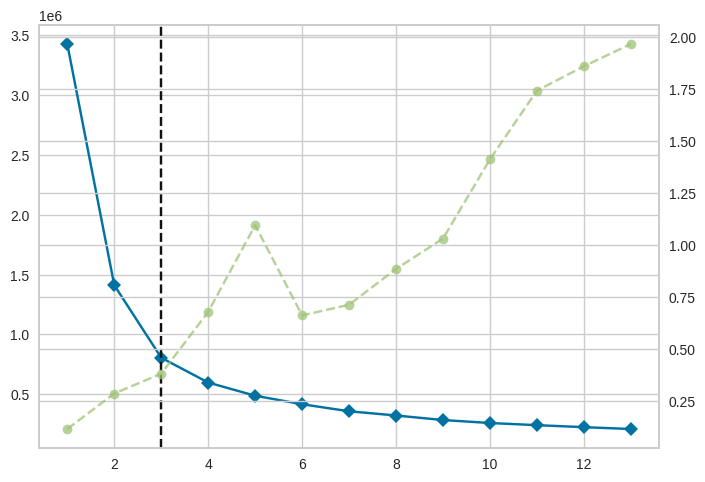

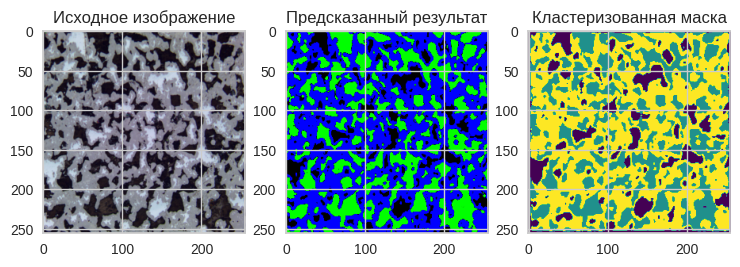

Количество кластеров: 3


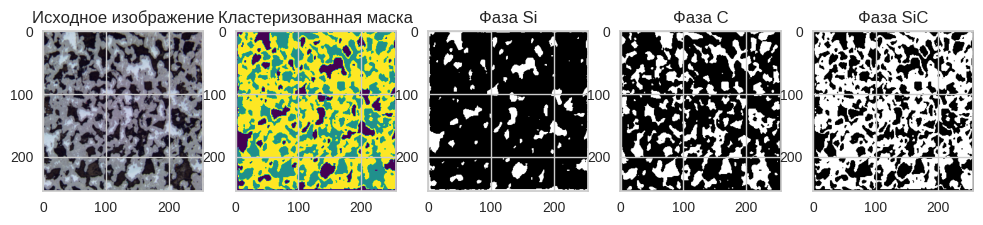


Содержание фазы Si: 15.23%

Содержание фазы C: 29.88%

Содержание фазы SiC: 54.90%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

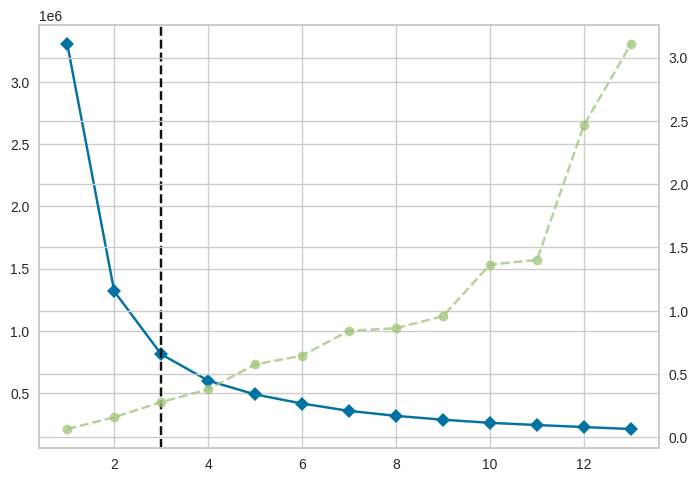

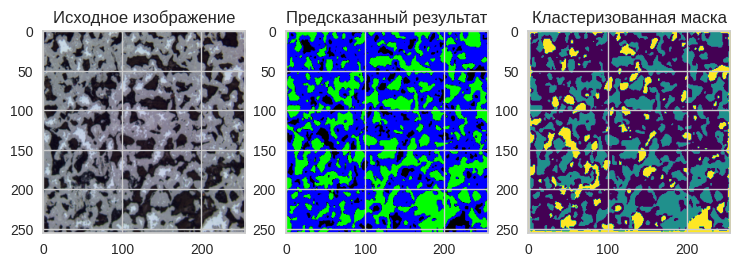

Количество кластеров: 3


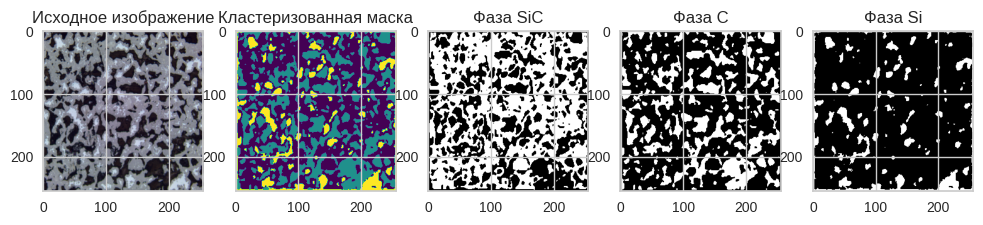


Содержание фазы SiC: 55.50%

Содержание фазы C: 30.16%

Содержание фазы Si: 14.34%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

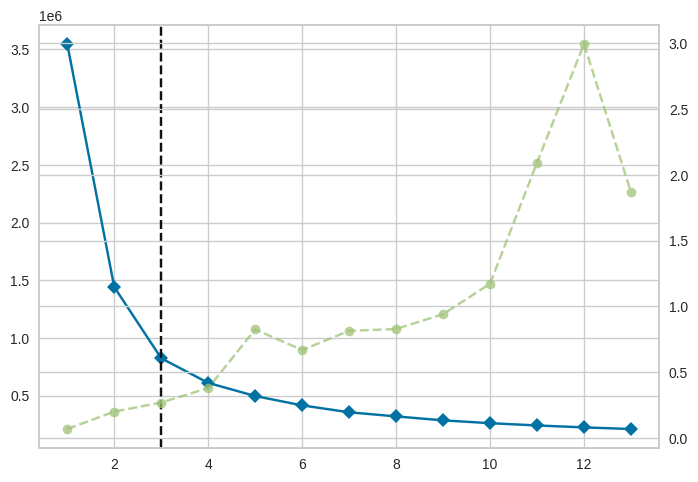

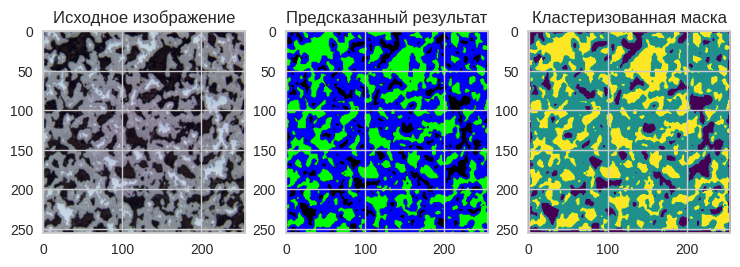

Количество кластеров: 3


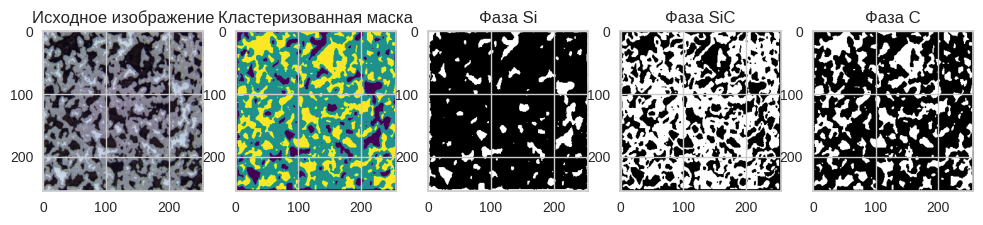


Содержание фазы Si: 15.47%

Содержание фазы SiC: 54.81%

Содержание фазы C: 29.72%

 Среднее содержание фаз:
Фаза Si: 15.75%
Фаза C: 29.75%
Фаза SiC: 54.50%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from skimage import color

class CustomDataset(Dataset):
    def __init__(self, image_folder_jpg, transform=None):
        self.image_folder_jpg = image_folder_jpg
        self.transform = transform
        self.jpg_files = [os.path.join(self.image_folder_jpg, filename) for filename in os.listdir(self.image_folder_jpg) if filename.endswith('.jpg')]

    def __len__(self):
        return len(self.jpg_files)

    def __getitem__(self, idx):
        image_path = self.jpg_files[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=3, padding=1),
              nn.ReLU(inplace=True),
              nn.Conv2d(64, 64, kernel_size=3, padding=1),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),
          )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
          )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

trained_model = UNet()
# please upload and specify the correct path to the model data unet_modelceramicnorm.pth and used device (CPU/GPU)
trained_model.load_state_dict(torch.load('/content/unet_modelceramicnorm.pth', map_location=torch.device('cpu')))
trained_model.eval()

image_folder = '/content/mineral'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = CustomDataset(image_folder, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

color_names = ["black", "green", "blue"]
new_thresholds = [(60, 100), (0, 30), (30, 60)]

color_mapping = {
"black": "Si",
"green": "C",
"blue": "SiC"
}

def plot_lab_clusters(input_image_lab, clustered_mask, num_clusters):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, num_clusters + 2, 1)
  plt.imshow(color.lab2rgb(input_image_lab))
  plt.title("Initial image")

  plt.subplot(1, num_clusters + 2, 2)
  plt.imshow(clustered_mask, cmap='viridis')
  plt.title("Clustered mask")

  for label in range(num_clusters):
    cluster_mask = clustered_mask == label
    plt.subplot(1, num_clusters + 2, label + 3)
    plt.imshow(cluster_mask, cmap='gray')

# define the cluster color basing on threshold in Lab space
    cluster_pixels_L = input_image_lab[:, :, 0][cluster_mask]
    mean_L = np.mean(cluster_pixels_L)
    cluster_color = None
    for i, (low, high) in enumerate(new_thresholds):
      if low <= mean_L <= high:
        cluster_color = color_names[i]
        break

    if cluster_color is None:
      cluster_color = "undefined"

    cluster_info = color_mapping.get(cluster_color, "undefined")
    plt.title(f"Phase {cluster_info}")

  plt.show()

phase_totals = {phase: 0 for phase in color_mapping.values()}
image_count = 0

for batch in dataloader:
  image = batch[0]
  image = image.unsqueeze(0)

  with torch.no_grad():
    output = trained_model(image)
    output = torch.nn.functional.interpolate(output, size=(256, 256), mode='bilinear', align_corners=False)

  input_image = image.squeeze(0).permute(1, 2, 0).numpy()
  predicted_mask = output[0].permute(1, 2, 0).numpy()
  predicted_mask_reshaped = predicted_mask.reshape(-1, 3)

  visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1, 14))
  visualizer.fit(predicted_mask_reshaped)
  optimal_num_clusters = visualizer.elbow_value_

  if optimal_num_clusters is None or optimal_num_clusters > 3:
    optimal_num_clusters = 3

  kmeans = KMeans(n_clusters=optimal_num_clusters, n_init=10, random_state=0)
  kmeans.fit(predicted_mask_reshaped)
  cluster_labels = kmeans.labels_
  clustered_mask = cluster_labels.reshape(predicted_mask.shape[:2])

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 4, 1)
  plt.imshow(input_image)
  plt.title("Initial image")

  plt.subplot(1, 4, 2)
  plt.imshow(predicted_mask, cmap='gray')
  plt.title("Predicted result (mask)")

  plt.subplot(1, 4, 3)
  plt.imshow(clustered_mask, cmap='viridis')
  plt.title("Clustered mask")
  plt.show()

  unique_labels, counts = np.unique(cluster_labels, return_counts=True)
  num_clusters = len(unique_labels)
  total_pixels = np.product(predicted_mask.shape[:2])

  print(f"Number of clusters: {num_clusters}")

  input_image_resized = input_image.reshape(predicted_mask.shape[0], predicted_mask.shape[1], 3)
  image_lab = color.rgb2lab(input_image_resized)

  plot_lab_clusters(image_lab, clustered_mask, num_clusters)

  for label, count in zip(unique_labels, counts):
      percentage = (count / total_pixels) * 100

      image_lab = color.rgb2lab(input_image_resized)


      L_channel = image_lab[:,:,0]
      a_channel = image_lab[:,:,1]
      b_channel = image_lab[:,:,2]

      cluster_mask = clustered_mask == label
      cluster_pixels_L = L_channel[cluster_mask]
      cluster_pixels_a = a_channel[cluster_mask]
      cluster_pixels_b = b_channel[cluster_mask]


      mean_L = np.mean(cluster_pixels_L)
      mean_a = np.mean(cluster_pixels_a)
      mean_b = np.mean(cluster_pixels_b)


      cluster_color = None
      for i, (low, high) in enumerate(new_thresholds):
          if low <= mean_L <= high:
              cluster_color = color_names[i]
              break

      if cluster_color is None:
          cluster_color = "undefined"

      cluster_info = color_mapping.get(cluster_color, "undefined")
      phase_totals[cluster_info] += percentage
      print()
      print(f"Phase content {cluster_info}: {percentage:.2f}%")


  image_count +=1

average_phases = {phase: total / image_count for phase, total in phase_totals.items()}

print("\n Mean phases content:")
for phase, avg_percentage in average_phases.items():
    print(f"Phase {phase}: {avg_percentage:.2f}%")